<h1> ARBNB </h1>
<hr>

Este es el notebook donde se desarrollará el caso de negocio para ARBNB. A continuación se realiza la carga de los módulos requeridos para el desarrollo del proyecto.

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import seaborn as sns

import re
import datetime as dt

from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score
import statsmodels.api as sm

from pycaret.regression import *

%matplotlib inline

Se realiza la carga de la base de datos:

In [2]:
df = pd.read_excel("muestra_airbnb_nyc.xlsx")

Esta base de datos cuenta con un total de 3.017 registros, de los cuales, se tienen 82 variables.

<h2> Limpieza y Selección de Variables </h2>
<hr>

Ahora se procede a realizar una limpieza de datos, acorde a lo que se tiene dentro de la base de datos.

In [3]:
df["year"] = df["host_since"].apply(lambda x: dt.datetime.utcfromtimestamp((x - 25569) * 86400.0).year if pd.notna(x) else x)
df["month"] = df["host_since"].apply(lambda x: dt.datetime.utcfromtimestamp((x - 25569) * 86400.0).month if pd.notna(x) else x)
df["street"] = df["street"].apply(
    lambda x: re.sub("Elmhurts|Elmhutst", "Elmhurst",
              re.sub("^N.+", "New York",
              re.sub(",\s*\w*\s*\w*", "",       
              re.sub("(\s*)$|^(\s+)", "",
              re.sub("(,\s+Ny)$", "",
              re.sub(",\s+United States", "", x.title()))))))
    )

Se procede a seleccionar las variables que pueden ser relevantes dentro del análisis. Para esto, se revisó variable por variable cuántos datos únicos contaba, y cada uno de estos cómo se representaban, por ejemplo, encontramos que más de 70% de las viviendas cuentan con un solo baño, por lo que esta no influye ya que su variabilidad es muy mínima.

In [4]:
df_text = df[['id','summary', 'description']]
df.drop(['host_id','name', 'summary', 'description', 'experiences_offered', 'neighborhood_overview', 'transit', 'house_rules', 'neighbourhood',  'street', 'host_since',
         'property_type', 'bed_type', 'amenities', 'calendar_updated', 'has_availability', 'check_in_24h', 'air_conditioning', 'high_end_electronics', 'bbq',
         'balcony', 'nature_and_views', 'bed_linen', 'breakfast', 'tv', 'coffee_machine', 'cooking_basics', 'white_goods', 'elevator', 'gym', 'child_friendly',
         'parking', 'outdoor_space', 'host_greeting', 'hot_tub_sauna_or_pool', 'internet', 'long_term_stays', 'pets_allowed', 'private_entrance', 'secure',
         'self_check_in', 'smoking_allowed', 'accessible', 'event_suitable', 'random','host_response_rate', 'host_is_superhost',
         'bathrooms', 'bedrooms', 'beds', 'guests_included', 'extra_people', 'availability_30',
         'availability_60', 'availability_90', 'availability_365','calculated_host_listings_count',
         'calculated_host_listings_count_entire_homes',
         'calculated_host_listings_count_private_rooms',
         'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
         'year', 'month'], axis = 1, inplace=True)

<h2> Análisis de Correlación </h2>
<hr>

Uno de los valores que nos puede indicar asociación entre las variables es el <strong> Coeficiente de correlación de Pearson </strong>. Este nos indica qué tan relacionada está una variable con respecto a otra de manera lineal.
El siguiente gráfico presenta la matriz de correlación entre las variables, buscando identificar alguna relación entre estas:

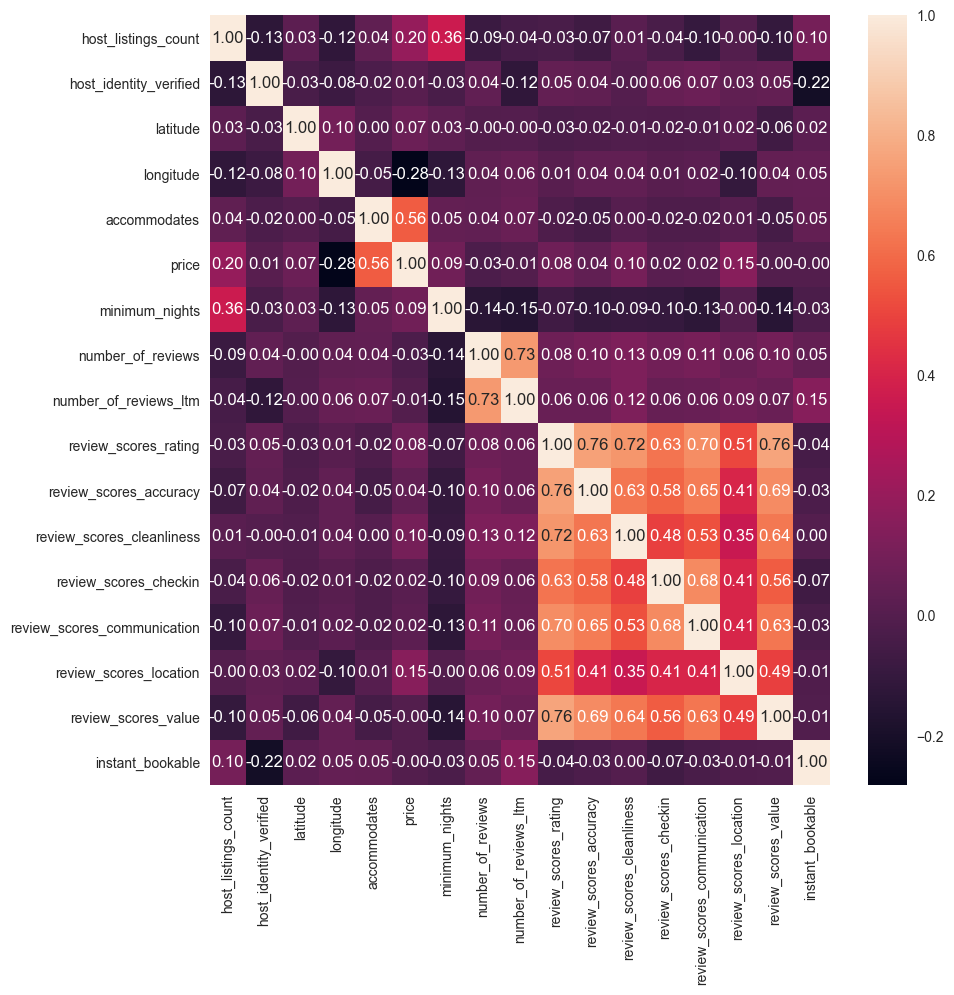

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
sns.heatmap(df.drop(["id"], axis=1).corr(), annot=True, ax = ax, fmt=".2f")

plt.show()

<h2> Segmentación de Viviendas </h2>
<hr>

Uno de los objetivos del análisis era generar una segmentación de las viviendas. Para ello se implementaron tres algoritmos de aprendizaje no supervizado. El <i> Kmeans </i>, <i> DBSCAN </i> y <i> OPTICS </i>. Después de ensayar estos algoritmos, se encontró que el <i> Kmeans </i> presentaba mejor rendimiento que los demás algoritmos. Posterior a esto, se determina el hiperparámetro que son la cantidad de grupos, determinada por dos métricas: <i> Davies Bound Score </i> y  <i> Silhouette Score </i>.

In [6]:
df_Numbers = pd.get_dummies(df.drop(['id'], axis=1)).fillna(0)
index = []
sil_score = []
davies_score = []
for i in range(2,16):
    index.append(i)
    sil_score.append(np.round(silhouette_score(df_Numbers, KMeans(n_clusters=i, n_init='auto').fit_predict(df_Numbers)), 3))
    davies_score.append(np.round(davies_bouldin_score(df_Numbers, KMeans(n_clusters=i, n_init='auto').fit_predict(df_Numbers)), 3))

pd.DataFrame({"Grupos":index, "Silhouette Score":sil_score, "Davies Bouldin Score":davies_score}).sort_values("Davies Bouldin Score", ascending=True)

Grupos  Silhouette Score  Davies Bouldin Score
7        9             0.527                 0.588
4        6             0.511                 0.647
6        8             0.538                 0.658
2        4             0.464                 0.674
8       10             0.433                 0.674
9       11             0.504                 0.679
5        7             0.504                 0.680
10      12             0.424                 0.685
3        5             0.483                 0.704
13      15             0.456                 0.723
12      14             0.421                 0.739
11      13             0.442                 0.741
1        3             0.516                 0.756
0        2             0.542                 1.095

Revisado los resultados, se consideró que la cantidad óptima para el análisis es un total de <strong> 6 </strong> grupos.

In [7]:
df["Kmeans"] = KMeans(n_clusters=6, n_init='auto').fit_predict(df_Numbers).astype(str)
df["host_identity_verified"] = pd.Categorical(df["host_identity_verified"].fillna(0).astype(int))

Se crea un mapa donde se tiene la segmentación generada por el algoritmo:

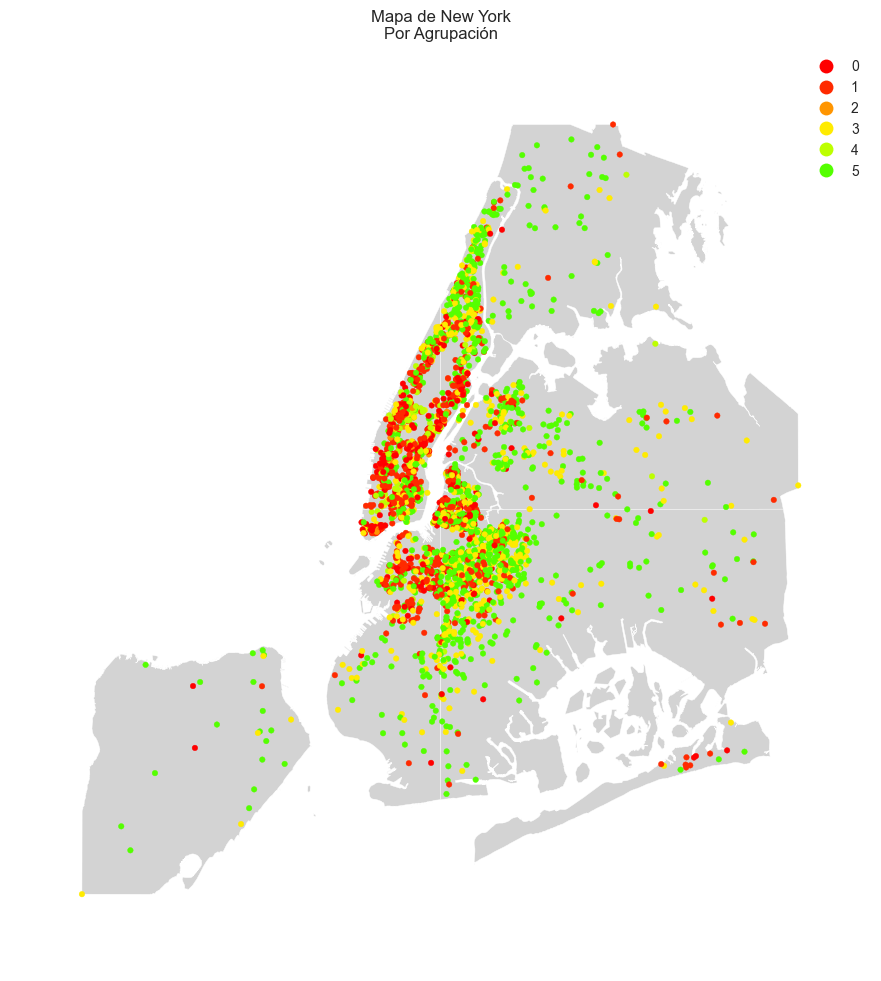

In [8]:
nyc_boroughs = gpd.read_file(gplt.datasets.get_path('nyc_boroughs'))

df_gp = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"])
)

ax = gplt.quadtree(
    df_gp,
    projection=gcrs.AlbersEqualArea(), 
    clip=nyc_boroughs,
    facecolor='lightgray',
    edgecolor='white',
    zorder=0,
    figsize=(12,12)
)

gplt.pointplot(
    df_gp,
    ax = ax,
    hue = "Kmeans",
    s = 4,
    legend = True,
    legend_var='hue', cmap = "prism")

ax.set_title("Mapa de New York\nPor Agrupación")

plt.show()

Creada la categorización, presentamos la distribución de cada uno de estos grupos, con respecto a las variables de <strong> precio </strong> y <strong> review </strong> que contaba la base de datos:

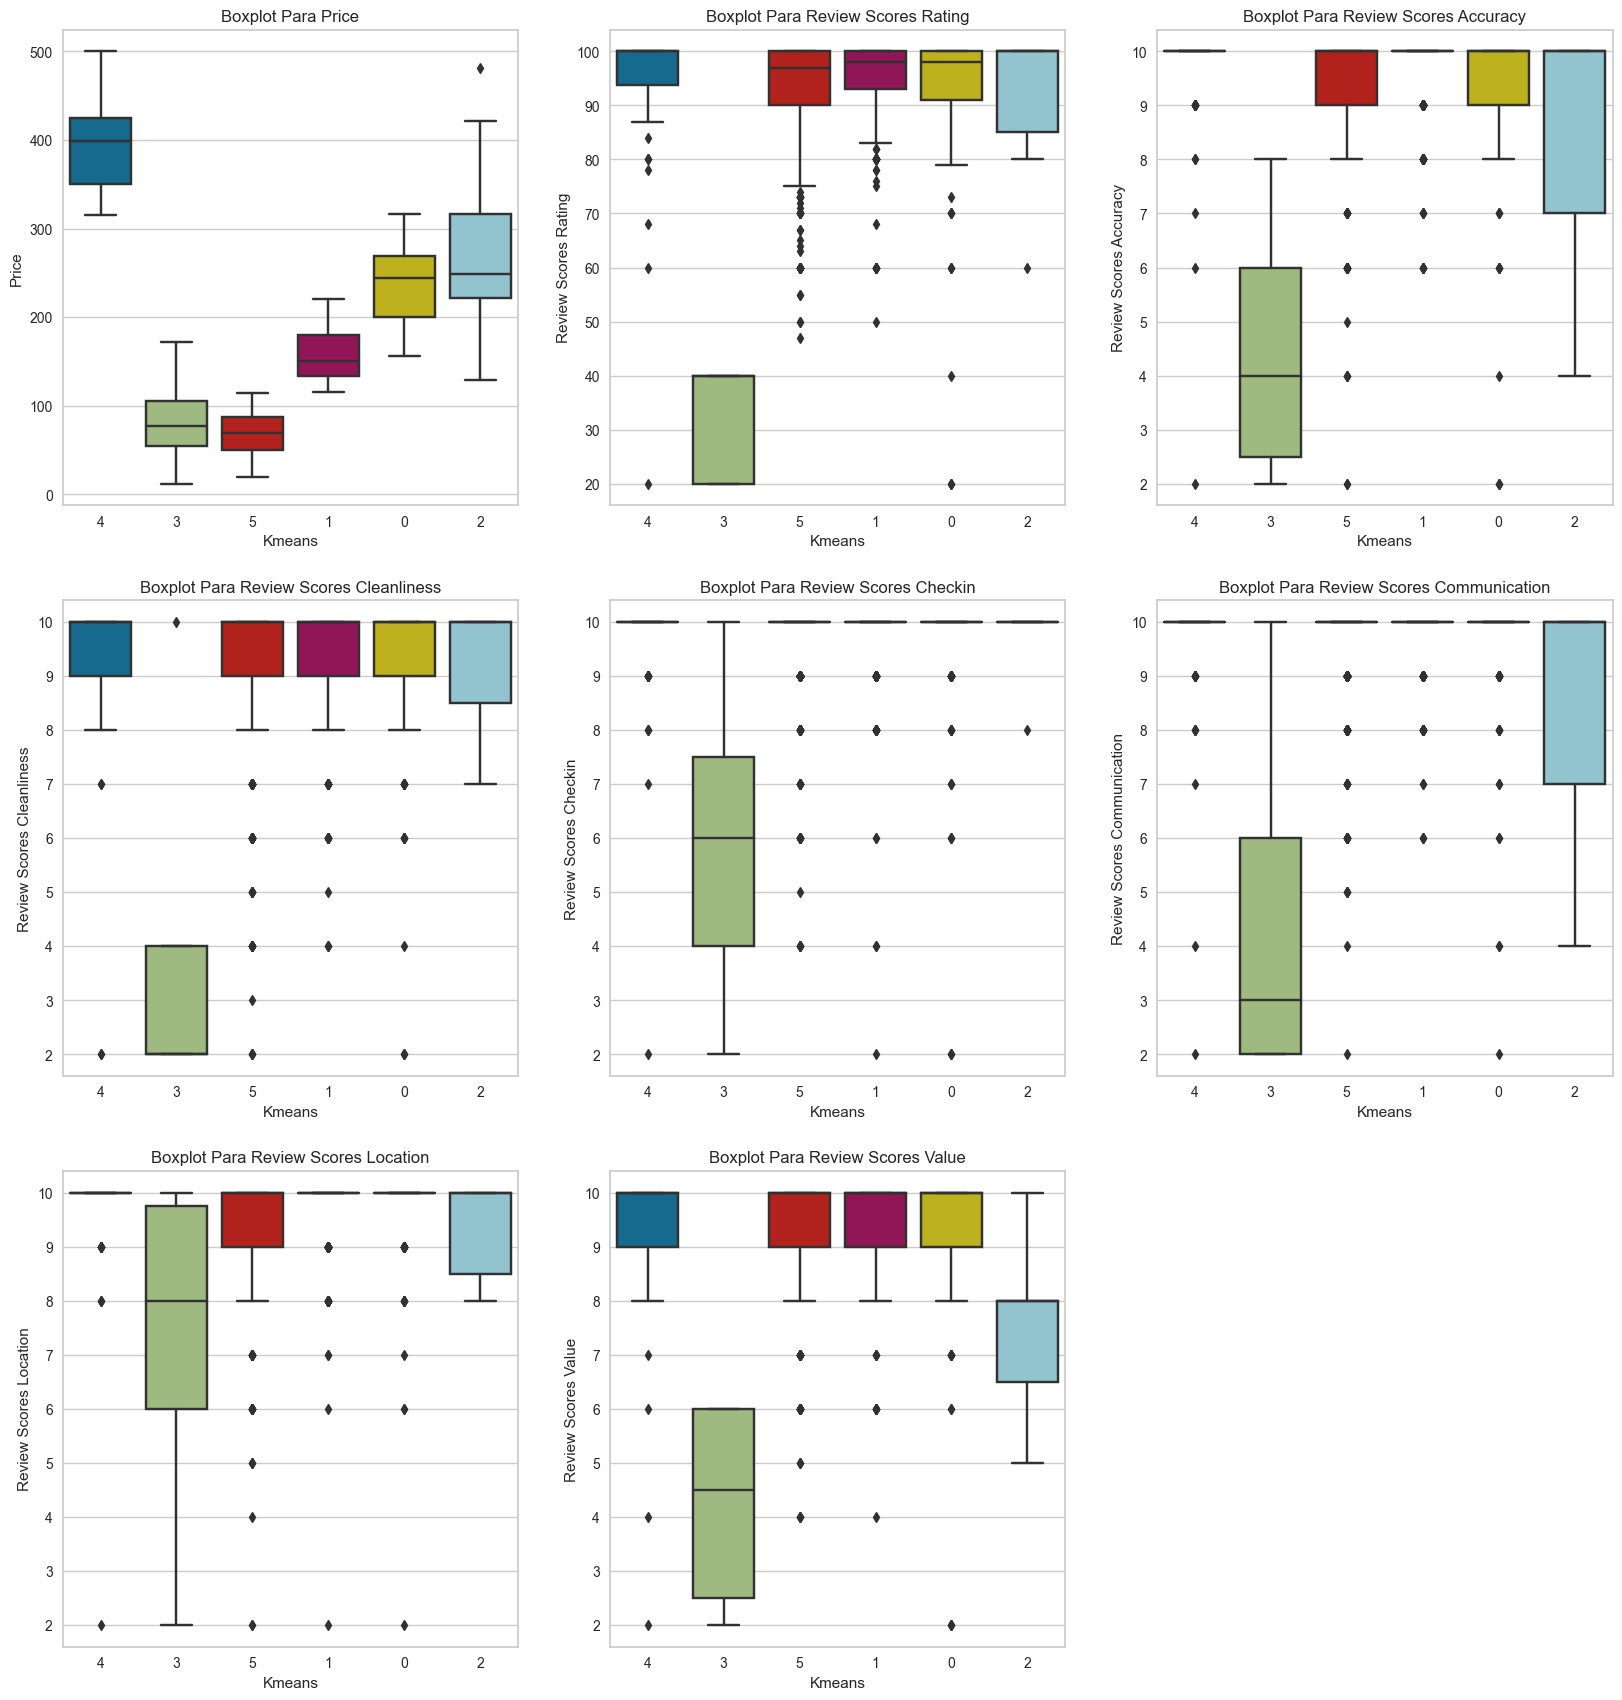

In [9]:
Review = []
for i in df.columns:
    if bool(re.match("review.", i))|bool(re.match("price", i)):
        Review.append(i)

Variables = []
for j in range(3):
    d = []
    for k in range(3):
        if len(Review) > j*3+k:
            d.append(Review[j*3+k])
        else:
            d.append('.')
    Variables.append(d)

fig, ax = plt.subplot_mosaic(Variables, figsize = (20, 21))

for i in Review:
    sns.boxplot(data = df, x = "Kmeans", y = i, ax = ax[i])
    ax[i].set_ylabel(re.sub("_", " ", i).title())
    ax[i].set_xlabel("Kmeans")
    ax[i].set_title("Boxplot Para " + re.sub("_", " ", i).title())

Como vemos, hay ciertos grupos que presentan unos valores bajos de precios, y otros muy altos, estos grupos son los que son foco de atención para poder mejorar. El siguiente gráfico presenta la los gráficos de puntos entre el <strong> Precio </strong> y las demás variables, junto con los segmentos generados por el algoritmo de aprendizaje no supervizado.

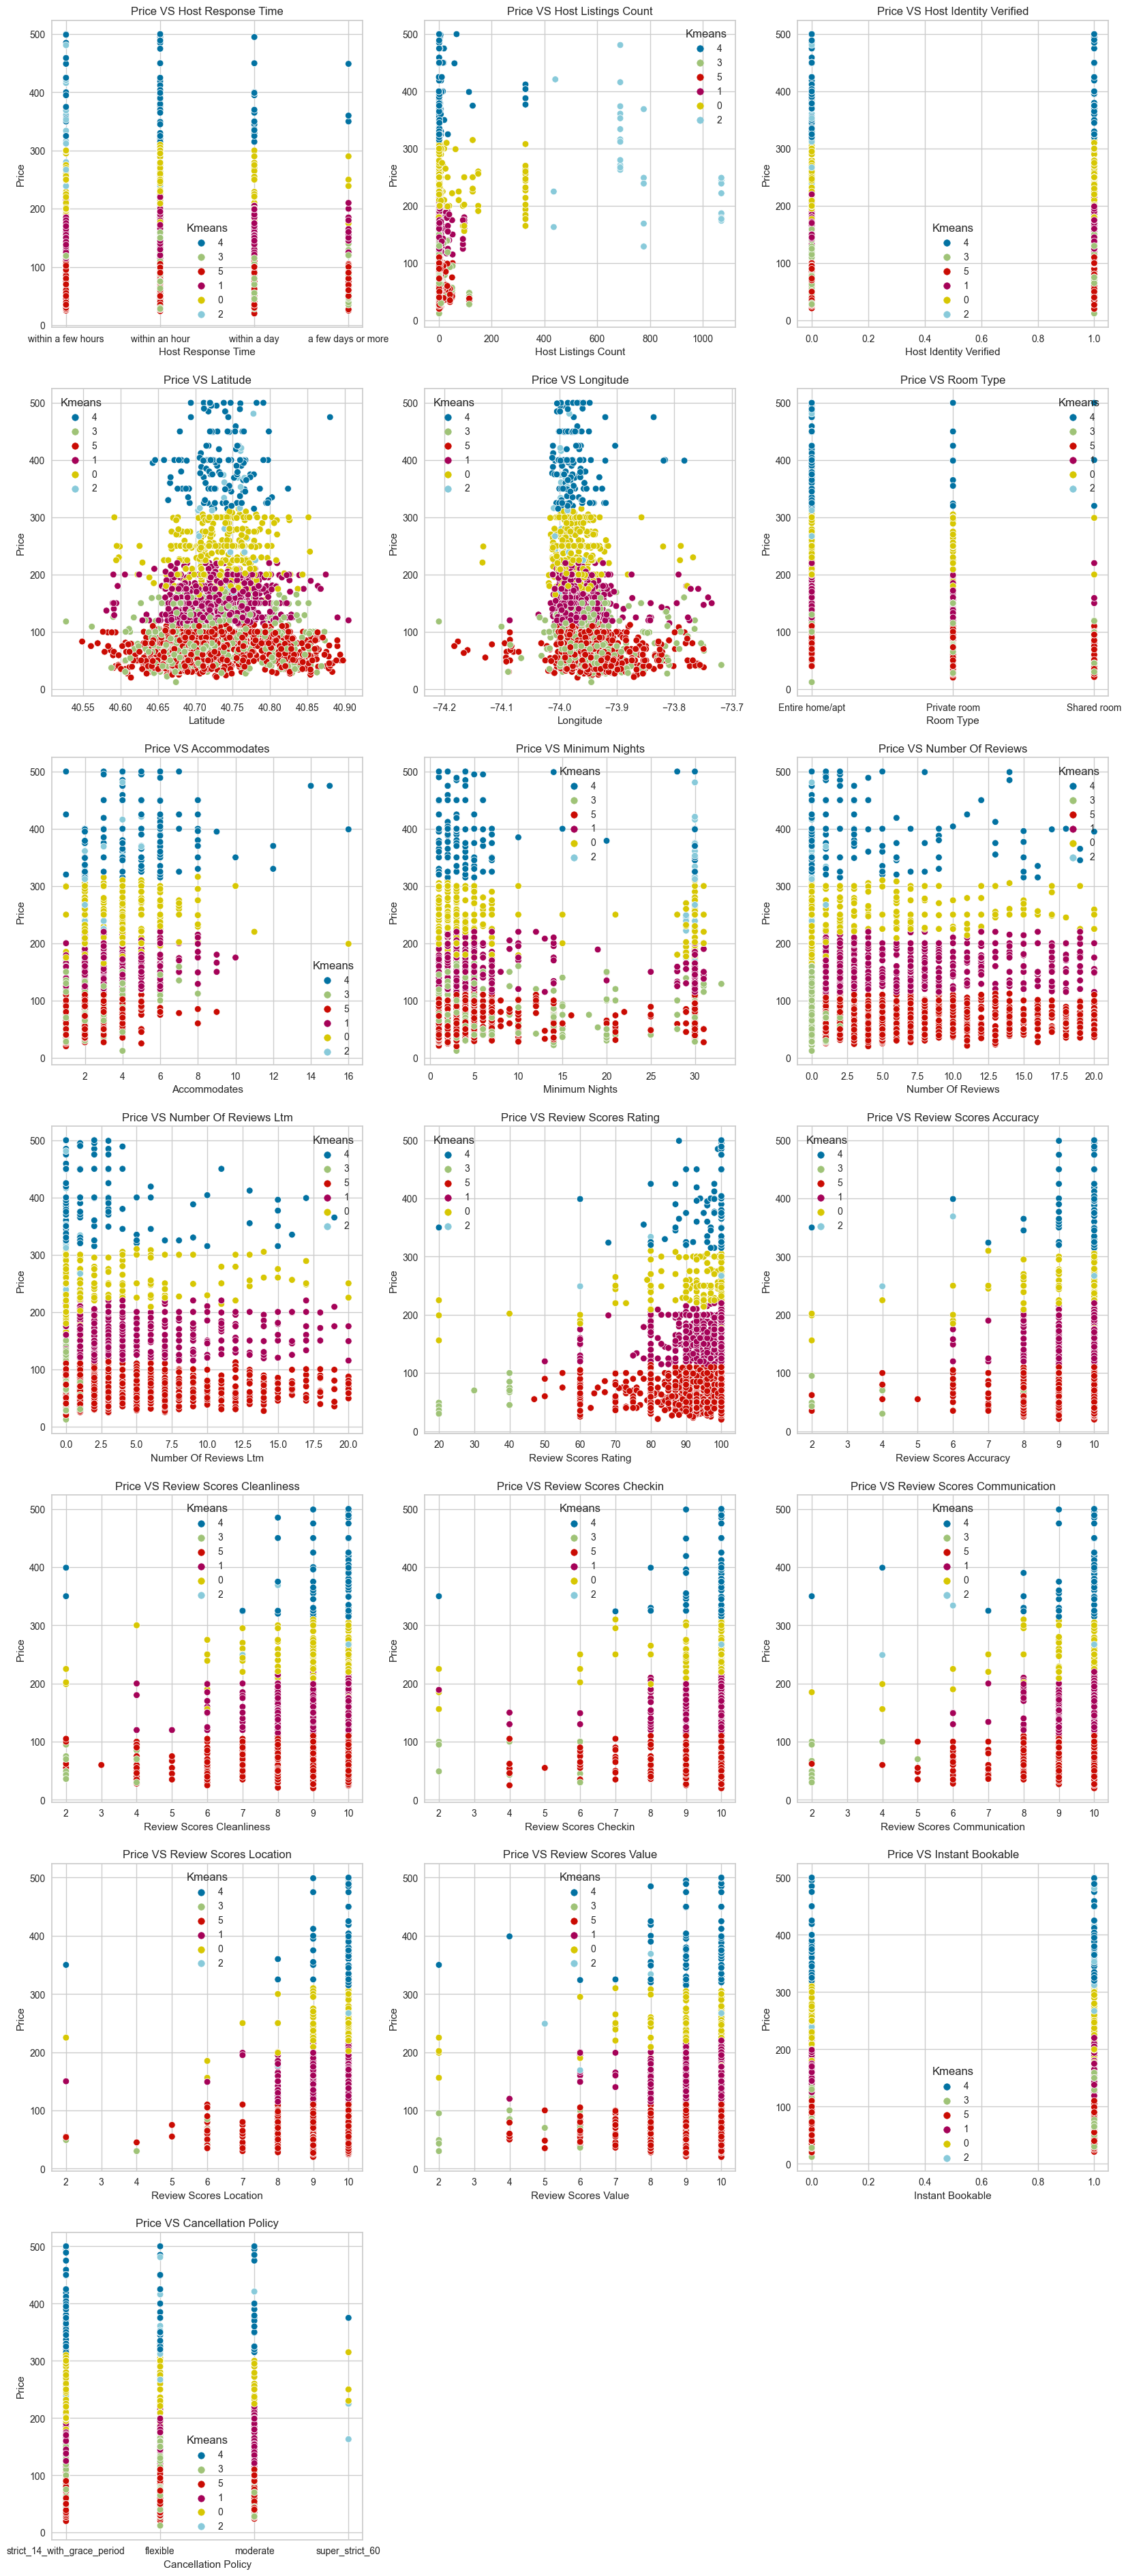

In [10]:
Variables = []
for j in range(7):
    d = []
    for k in range(3):
        if len(df.columns.drop(["id", "price", "Kmeans"])) > j*3+k:
            d.append(df.columns.drop(["id", "price", "Kmeans"])[j*3+k])
        else:
            d.append('.')
    Variables.append(d)

fig, ax = plt.subplot_mosaic(Variables, figsize = (20, 48))

for i in df.columns.drop(["id", "price", "Kmeans"]):
    sns.scatterplot(data = df, x = i, y = "price", hue="Kmeans", ax = ax[i])
    ax[i].set_xlabel(re.sub("_", " ", i).title())
    ax[i].set_ylabel("Price")
    ax[i].set_title("Price VS " + re.sub("_", " ", i).title())

<h2> Grupos Foco </h2>
<hr>

Como vimos anteriormente, hay grupos foco los cuales se encontró que estaban teniendo cierto comportamiento diferencial con los demás grupos. Revisaremos estos grupos con el fin de ver oportunidades de mejora:

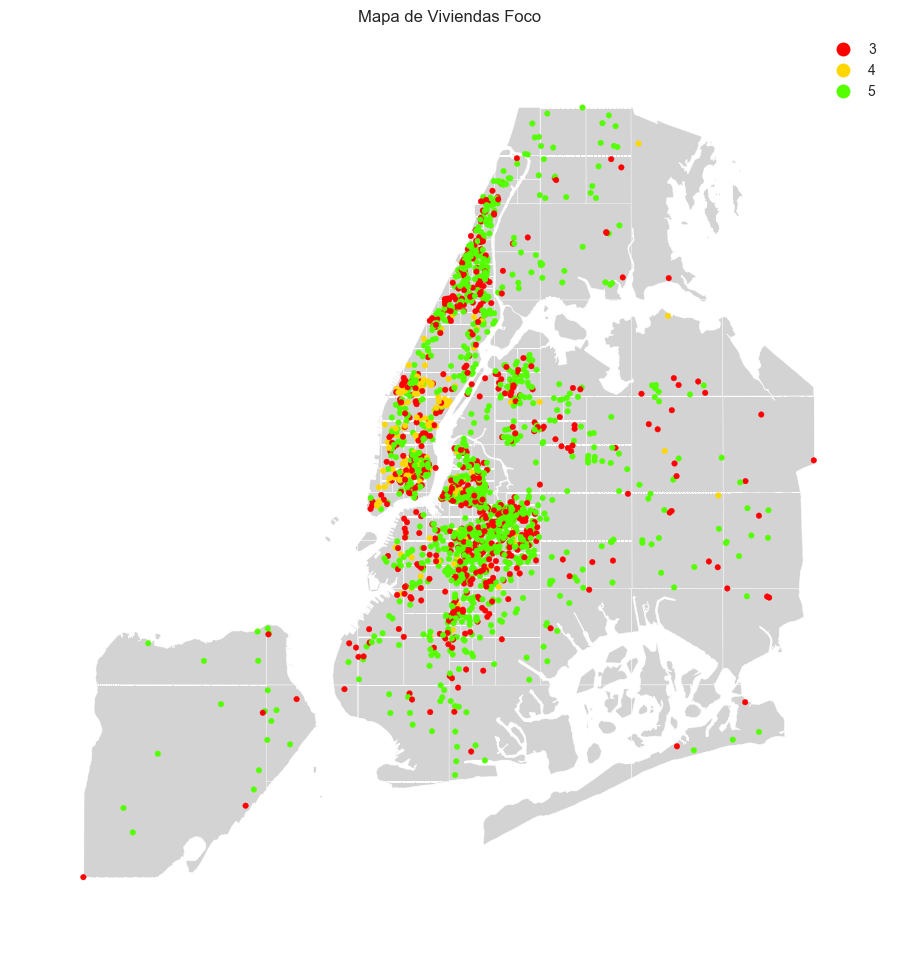

In [11]:
Grupos_Foco = (
    df.
    drop("id", axis = 1).
    groupby("Kmeans").
    mean(numeric_only = True).
    sort_values("price").
    iloc[[0,1,5],:].
    reset_index()
    ["Kmeans"]
)

Viviendas_Foco = df.loc[df["Kmeans"].isin(Grupos_Foco), :]

Viviendas_Foco_gp = gpd.GeoDataFrame(
    Viviendas_Foco, 
    geometry=gpd.points_from_xy(Viviendas_Foco["longitude"], Viviendas_Foco["latitude"])
)

ax = gplt.quadtree(
    Viviendas_Foco_gp, nmax=1,
    projection=gcrs.AlbersEqualArea(), clip=nyc_boroughs,
    facecolor='lightgray', edgecolor='white', zorder=0,
    figsize=(12,12)
)

gplt.pointplot(Viviendas_Foco_gp, ax = ax, hue = "Kmeans", s = 4, legend = True, legend_var='hue', cmap = "prism")
ax.set_title("Mapa de Viviendas Foco")
plt.show()

Finalmente evaluamos los grupos foco con respecto a las variables de interés:

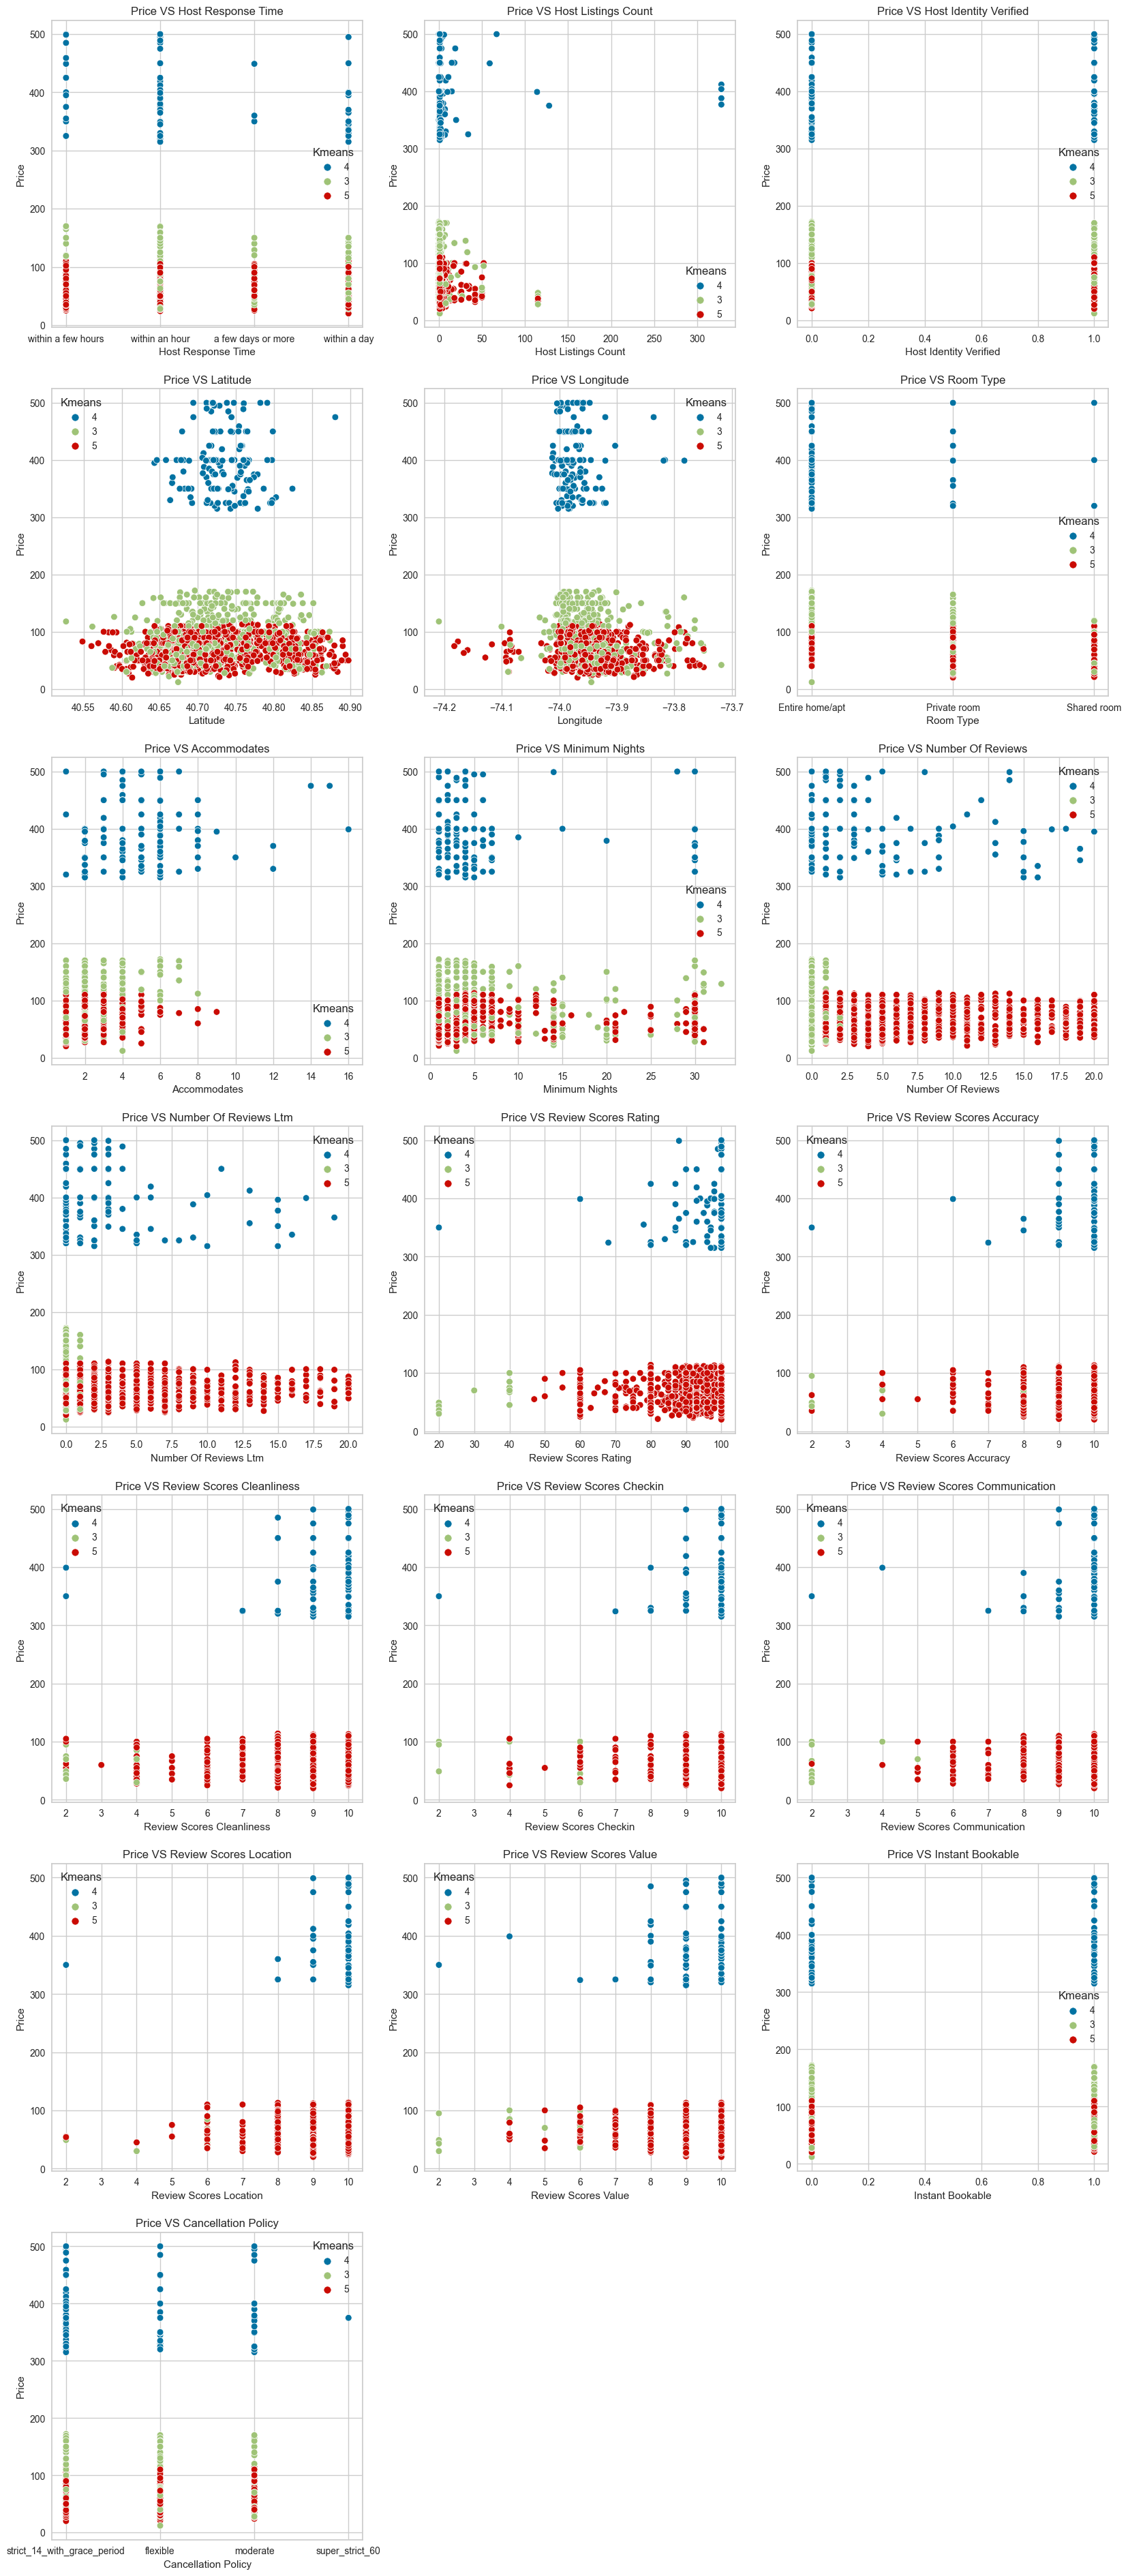

In [12]:
Variables = []
for j in range(7):
    d = []
    for k in range(3):
        if len(df.columns.drop(["id", "price", "Kmeans"])) > j*3+k:
            d.append(df.columns.drop(["id", "price", "Kmeans"])[j*3+k])
        else:
            d.append('.')
    Variables.append(d)

fig, ax = plt.subplot_mosaic(Variables, figsize = (20, 48))

for i in df.columns.drop(["id", "price", "Kmeans"]):
    sns.scatterplot(data = df.loc[df["Kmeans"].isin(Grupos_Foco)], x = i, y = "price", hue="Kmeans", ax = ax[i])
    ax[i].set_xlabel(re.sub("_", " ", i).title())
    ax[i].set_ylabel("Price")
    ax[i].set_title("Price VS " + re.sub("_", " ", i).title())

<h2> Predicción de Precio </h2>
<hr>

Para la predicción de los precios, utilizaremos la librería <strong> PyCaret </strong>, que permite comparar diferentes modelos y determinar cuál es el mejor modelo que podría predecir la variable objetivo, en este caso <i> Precio </i>.

Lo primero es configurar el modelo. Se crea una muestra de 80% del total de lo datos, y el 20% para validar el modelo.

In [13]:
df_train = df.sample(frac=0.8, random_state=1)
df_test = df.loc[~df["id"].isin(df_train["id"])]
s = setup(data = df_train, target="price")

Ahora se comparan los diferentes modelos que se pueden emplear:

In [14]:
best = compare_models()

El mejor modelo fue el <strong> gradient boost regressor </strong>, por lo que se procede a crear el modelo:

In [15]:
gbr = create_model('gbr')

Ahora con el modelo definido, se procede a verificar qué tan bien está prediciendo con los datos de test:

In [16]:
predict_model(gbr, data=df_test)

id  host_response_time  host_listings_count  \
14     4309079  within a few hours                  1.0   
15    28608462      within an hour                 35.0   
18    14010951                 NaN                  1.0   
20    24086178                 NaN                  1.0   
25    17763785      within an hour                  2.0   
...        ...                 ...                  ...   
2992  30013028                 NaN                  1.0   
2995  35069416      within an hour                  8.0   
2997   2723338                 NaN                  2.0   
2999  28339611                 NaN                  1.0   
3009  13312914                 NaN                  1.0   

     host_identity_verified   latitude  longitude        room_type  \
14                        0  40.726028 -73.988968     Private room   
15                        0  40.692451 -73.956573      Shared room   
18                        0  40.716862 -73.956482     Private room   
20                        0  40.775162 -73.917923  Entire home/apt   
25                        0  40.767220 -73.985680  Entire home/apt   
...                     ...        ...        ...              ...   
2992                      0  40.692848 -73.920853     Private room   
2995                      0  40.606251 -74.088997      Shared room   
2997                      1  40.690262 -73.927010     Private room   
2999                      1  40.710190 -73.956841  Entire home/apt   
3009                      1  40.698090 -73.934349     Private room   

      accommodates  minimum_nights  number_of_reviews  ...  \
14               2               7                 15  ...   
15               1               1                 13  ...   
18               2               3                  0  ...   
20               3               5                  1  ...   
25               3               5                  6  ...   
...            ...             ...                ...  ...   
2992             2               3                  0  ...   
2995             1               4                  1  ...   
2997             2               4                  2  ...   
2999             2               5                  2  ...   
3009             2               2                  0  ...   

      review_scores_cleanliness  review_scores_checkin  \
14                          8.0                   10.0   
15                          8.0                   10.0   
18                          NaN                    NaN   
20                         10.0                   10.0   
25                         10.0                   10.0   
...                         ...                    ...   
2992                        NaN                    NaN   
2995                        4.0                    6.0   
2997                        9.0                   10.0   
2999                        6.0                   10.0   
3009                        NaN                    NaN   

      review_scores_communication  review_scores_location  \
14                           10.0                    10.0   
15                           10.0                     9.0   
18                            NaN                     NaN   
20                           10.0                    10.0   
25                           10.0                    10.0   
...                           ...                     ...   
2992                          NaN                     NaN   
2995                          2.0                     4.0   
2997                         10.0                     8.0   
2999                         10.0                    10.0   
3009                          NaN                     NaN   

      review_scores_value  instant_bookable          cancellation_policy  \
14                    9.0                 0                     moderate   
15                   10.0                 1                     flexible   
18                    NaN                 0                